# Inference example of timbre transfer with dual latent diffusion bridge

Add the main tssb folder to the system path, or navigate (cd) to that directory to ensure modules can be imported correctly.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from main.module_base_latent_cond import (
    Model, 
    AudioDiffusionModel,
)


from audio_diffusion_pytorch import (
    KarrasSamplerReverse, 
    KarrasSampler,
    KarrasSchedule,
    KDistribution,
    PitchTracker,
    NormalizedEncodec,
    plot_spec, 
    play_audio
)
import torch
import torchaudio
from IPython.display import HTML
from typing import Dict, Any

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Distribution, Schedule, and Samplers

- **`sigma_min`**, **`sigma_max`**, and **`rho`** will define the **`diffusion_sigma_distribution`**, creating a distribution of sigmas following **Formula 1** from the reference paper.

- **`diffusion_schedule`** follows the Karras scheduling algorithm to manage the progression of sigma values during the diffusion process.

The following samplers implement the Karras sampling algorithm:
- **`diffusion_sampler_reverse`**: Handles the reverse diffusion process (adding noise to audio).
- **`diffusion_sampler`**: Handles the forward diffusion process (denoising from noise).



In [2]:
sigma_min = 0.001
sigma_max = 5
rho = 9.0

diffusion_sigma_distribution = KDistribution(sigma_min = sigma_min, sigma_max = sigma_min, rho = rho)
diffusion_schedule = KarrasSchedule(sigma_min=sigma_min, sigma_max=sigma_max, rho=rho)  

diffusion_sampler_reverse = KarrasSamplerReverse()
diffusion_sampler = KarrasSampler()

## Creating and Loading the Diffusion and PyTorch Lightning Models

In [3]:
# Loading flute model
diffusion_model_flute = AudioDiffusionModel(
    diffusion_sigma_distribution =  diffusion_sigma_distribution,
)

flute_mean_path  = '/mnt/beegfs/group/mt/yurii/tssb/tensors/mean_tensor_enc_flute.pt'
flute_std_path = '/mnt/beegfs/group/mt/yurii/tssb/tensors/std_tensor_enc_flute.pt'
flute_model_weights = '/mnt/beegfs/group/mt/yurii/tssb/logs/michele/flute_old_s100.ckpt'

# Pytorch lighting model
pl_model_flute = Model(
    model = diffusion_model_flute,
    mean_path = flute_mean_path,
    std_path = flute_std_path,
)

ckpt_flute = torch.load(flute_model_weights, map_location=device)    
pl_model_flute.load_state_dict(ckpt_flute["state_dict"], strict=True)
pl_model_flute.to(device)

# Loading violin model
diffusion_model_violin = AudioDiffusionModel(
    diffusion_sigma_distribution =  diffusion_sigma_distribution,
)

violin_mean_path  = '/mnt/beegfs/group/mt/yurii/tssb/tensors/mean_tensor_enc_violin.pt'
violin_std_path = '/mnt/beegfs/group/mt/yurii/tssb/tensors/std_tensor_enc_violin.pt'
violin_model_weights = '/mnt/beegfs/group/mt/yurii/tssb/logs/michele/violin_old_s100.ckpt'

# Pytorch lighting model
pl_model_violin = Model(
    model = diffusion_model_violin,
    mean_path = violin_mean_path,
    std_path = violin_std_path,
)

ckpt_violin = torch.load(violin_model_weights, map_location=device)    
pl_model_violin.load_state_dict(ckpt_violin["state_dict"], strict=True)
pl_model_violin.to(device)

Model(
  (encodec_model): EncodecModel(
    (encoder): EncodecEncoder(
      (layers): ModuleList(
        (0): EncodecConv1d(
          (conv): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
        )
        (1): EncodecResnetBlock(
          (block): ModuleList(
            (0): ELU(alpha=1.0)
            (1): EncodecConv1d(
              (conv): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
            )
            (2): ELU(alpha=1.0)
            (3): EncodecConv1d(
              (conv): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
            )
          )
          (shortcut): EncodecConv1d(
            (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
          )
        )
        (2): ELU(alpha=1.0)
        (3): EncodecConv1d(
          (conv): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
        )
        (4): EncodecResnetBlock(
          (block): ModuleList(
            (0): ELU(alpha=1.0)
            (1): EncodecConv1d(
              (conv): Conv1d(64, 32, kernel_size=

## Loading Audio and Converting to Encodec Embeddings

Input waveform shape: torch.Size([1, 1, 409600])


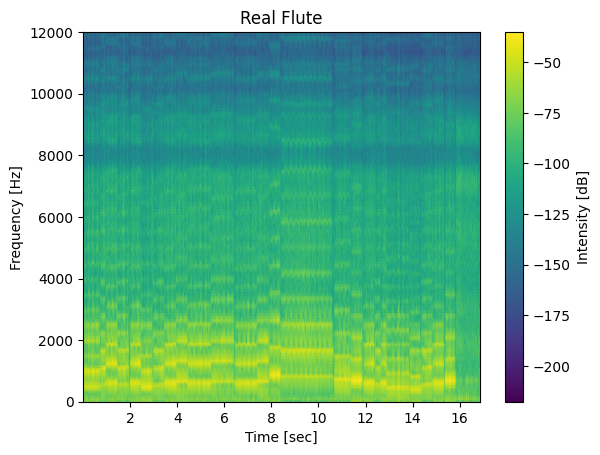

Input Encodec embeddings shape: torch.Size([1, 128, 1280])


In [4]:
sr = 24000
audio_path = '/mnt/beegfs/group/mfm/data/cocochorales_full/main_dataset/test_eval/flute/flute_231624'
waveform_raw, orig_sr = torchaudio.load(audio_path)
resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=sr)
waveform_raw = resampler(waveform_raw)
waveform_cpu = waveform_raw.unsqueeze(0)
waveform = waveform_cpu.to(device)

# Adjust the audio length to exactly 17 seconds with a sampling rate of 24,000 Hz, either by padding or cropping as needed.
pad_size = 409600 - waveform_cpu.shape[-1] 
flute_waveform = torch.nn.functional.pad(waveform, (0, pad_size))

print(f'Input waveform shape: {flute_waveform.shape}')
plot_spec(waveform_raw.numpy(), sr, title='Real Flute')
play_audio(waveform_raw.numpy(), sr)

# Conver the input audio to encodec embeddings
encodec = NormalizedEncodec(device=device)
embeddings_flute = encodec.encode_latent(flute_waveform, pl_model_flute.mean, pl_model_flute.std)
print(f'Input Encodec embeddings shape: {embeddings_flute.shape}')


## Perform Bridging

### Apply noise to the input audio using flute model, progressing through the forward diffusion steps to transform it into the shared latent space representation.

In [5]:
num_steps = 100
# Convert to Noise
noisy_flute_embeddings = pl_model_flute.model.sample(
    noise=embeddings_flute,
    sampler=diffusion_sampler_reverse,
    sigma_schedule=diffusion_schedule,
    num_steps=num_steps
)

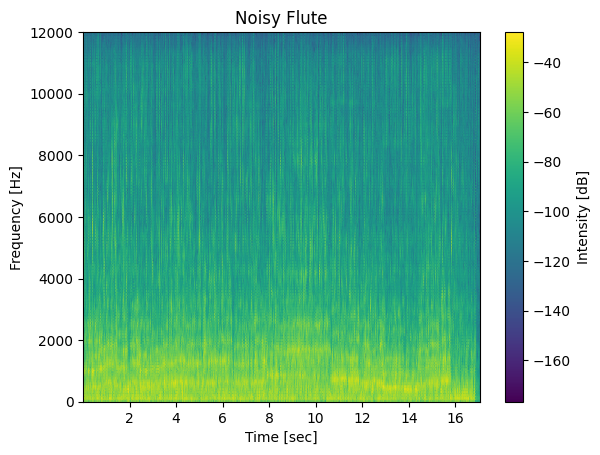

In [6]:
noise_waveform = encodec.decode_latent(noisy_flute_embeddings, pl_model_flute.mean, pl_model_flute.std)
noise_waveform = noise_waveform.cpu().detach().squeeze(0).numpy()
plot_spec(noise_waveform, sr, title='Noisy Flute')
play_audio(noise_waveform, sr)

### Use the violin model to denoise from the latent space, obtaining a corresponding point in the violin-specific space that matches the shared latent space representation.

In [7]:
generated_violin_embeddings = pl_model_violin.model.sample(
    noise=noisy_flute_embeddings,
    sampler=diffusion_sampler,
    sigma_schedule=diffusion_schedule,
    num_steps=num_steps
)

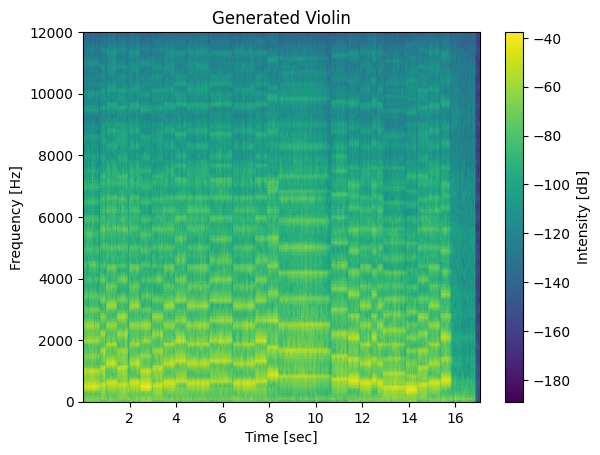

In [8]:
violin_waveform = encodec.decode_latent(generated_violin_embeddings, pl_model_violin.mean, pl_model_violin.std)
violin_waveform = violin_waveform.cpu().detach().squeeze(0).numpy()
plot_spec(violin_waveform, sr, title='Generated Violin')
play_audio(violin_waveform, sr)


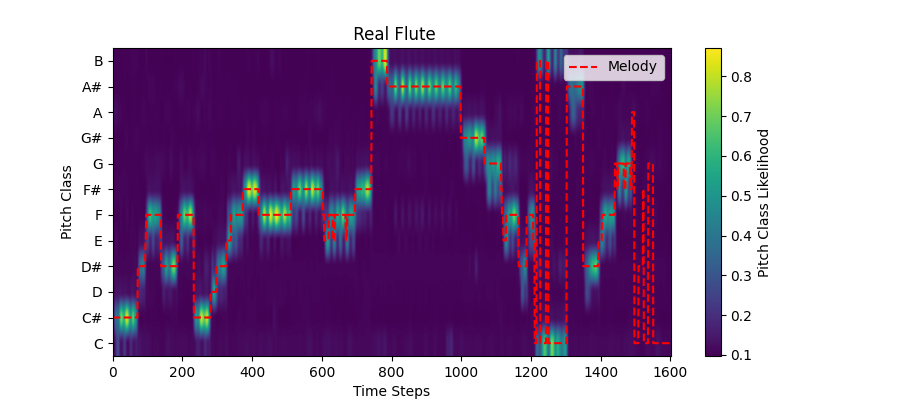
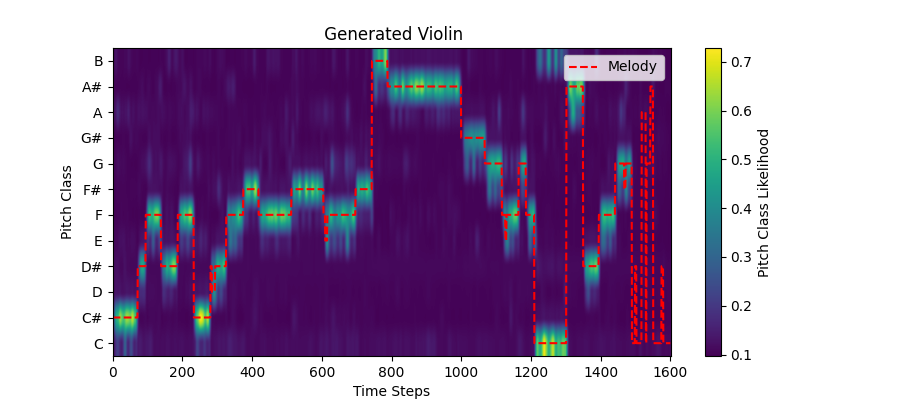

In [9]:
pitch_tracker = PitchTracker()
tracking_output = pitch_tracker.cals_pitch_metric(flute_waveform, torch.tensor(violin_waveform), 'both', plot=True, pair=('Real Flute', 'Generated Violin'))
dtw, jaccard = tracking_output[0][0]
img1, img2 = tracking_output[1]

dtw_rounded = round(dtw, 2)
jaccard_rounded = round(jaccard, 2)

html_content = f"""
<div style="text-align: center; margin-bottom: 20px;">
    <p><strong>DPD:</strong> {dtw_rounded} &nbsp;&nbsp; <strong>JD:</strong> {jaccard_rounded}</p>
</div>
<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        {img1}
    </div>
    <div style="flex: 1; text-align: center;">
        {img2}
    </div>
</div>
"""

display(HTML(html_content))